# Problem Statement

* Yammer provides a platform for users to communicate and share content; it's a social network. 
* They measure user engagement as users making some kind of server call by interacting with the project. 
* To visualize the metric, they plot number of users logging 1+ engagement in a given week
* The plot increases steadily until ~August 1st, at which point it drops by ~200 users (from 1400 to 1200) and then appears to flatten out again. 
* My task: determine the cause of the dip and recommend solutions, if appropriate

## Some considerations

The plot shows:

* How many users had 1+ engagement in the last 7 days (during the week starting on the given date)
* Change in the 1+ engagement metric per day

The plot DOES NOT show:

* How many "events" each user participated in during that week
* How spaced out multiple events were in each week, either per user or for the whole company
* Total number of events per week
* Any daily information

## Some possible explanations

1. Definition of "events" was narrowed or changed by disregarding things previously classified as "events". However, given the data, this seems unlikely. 
2. Platform made a change that discouraged users and/or caused them to become disengagged. I don't have any evidence of this event
3. Some project driving use of Yammer ended, thus the people working on the project stopped using the platform
4. Usage is measured in the summer; perhaps there were interns or other temporary employees using the service regularly from June 1 - August 1, but then they left. The somewhat gradual decline could be due to there being a range of end dates
5. Given the data cover many companies perhaps a particular company stopped using the platform, either due to loss of interest OR because that company went out of business or had to fire employees. 
6. Businesses have adopted new tools that make functionality in Yammer redundant; for instance, perhaps they adopted a new email platform and no longer use Yammer. 

The simplest and (in my opinion) likeliest explanation is #4. This can be tested by looking at users created around June 1st, checking their activity for the following 2 months, and seeing if those particular users are the ones who fell off in activity around August 1st. Based on the tables I've gotten, I might also be able to see if the users' states changed around August 1 as well

For #1 and #2, I don't really have the data to answer these questions. I would need to inquire about changes in features, and given the puzzlement of my superior, I infer that there have been no major changes. 

For #3 and #5, both are dependent on looking at company ID. So for that inquiry, I would pull events per company and look to see if a particular company or group of companies had a downturn in activity. 

For #6, I can look at event types to see if 1 or more particular types of events are suffering more than others. If so, this might point to another tool eating up a market share

Thus, my planned plan of action is:

1. Investigate possibility of seasonal employees using user_id creation date around June 1st by monitoring events by those users from ~June 1st to ~August 1st
2. Investigate possibility of 1 or more companies abandoning Yammer, possibly due to the success of those companies, by monitoring events for each company from ~June 1st to ~August 1st. 
3. Investigate possibility of losing market share to another tool by examining the change in event type with time. 


# Solution

* I think the most likely explanation is that seasonal employees ended their employment periods at the beginning of August; these were employees hired around April/May
* As evidence, employees hired past May have actually stayed about the same or INCREASED their event frequency as shown below

# Part 1: Getting + Cleaning Data

There are 4 CSV files; in this portion, I will read all of them into Python Pandas and make sure to deal with duplicates, missing data, and corrupted data

In [59]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [7]:
# Read in the 4 csv files
users = pd.read_csv("./yammer_users.csv", parse_dates=['created_at', 'activated_at'])
events = pd.read_csv("./yammer_events.csv", parse_dates = ['occurred_at'])
emails = pd.read_csv("./yammer_emails.csv", parse_dates = ['occurred_at'])
rollup = pd.read_csv("./dimension_rollup_periods.csv", parse_dates = ['time_id', 'pst_start', 
                                                                      'pst_end', 'utc_start', 
                                                                      'utc_end'])

I already know the expected number of columns for each dataset; I'm going to check that these look right, plus look for missing data

In [8]:
# Print out info
for item in [users, events, emails, rollup]:
    print(item.info())         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
user_id         19066 non-null float64
created_at      19066 non-null datetime64[ns]
company_id      19066 non-null float64
language        19066 non-null object
activated_at    9381 non-null datetime64[ns]
state           19066 non-null object
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 893.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
user_id        340832 non-null float64
occurred_at    340832 non-null datetime64[ns]
event_type     340832 non-null object
event_name     340832 non-null object
location       340832 non-null object
device         340832 non-null object
user_type      325255 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 18.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns)

In [24]:
print(users.drop_duplicates().shape)
print(events.drop_duplicates().shape)
print(emails.drop_duplicates().shape)
print(rollup.drop_duplicates().shape)

(19066, 6)
(340825, 7)
(90389, 4)
(56002, 6)


There's very few duplicate events in the "events" data frame, otherwise these are non-redundant. So I'll quickly just drop those duplicates

In [25]:
events = events.drop_duplicates()

Oddly enough, the 2nd table (events) has an extra column: "user_type"; it also shows up in the "emails" table. Perhaps I'll take a look at this and see what it is in a bit.

In terms of missing data, the user type is missing entries from the "Events" table and the activated_at is missing entries from the "Users" table. These may be useful to know later, but they don't seem to affect my intended plots much. 

One other note: on first pass, all the date-time data were interpreted as strings. To get around this, I simply added "parse_dates" for all the date-time columns to the CSV-reading statements

**Let's examine the "user_type" category

In [26]:
events.user_type.describe()

count    325248.000000
mean          1.512243
std           0.754781
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: user_type, dtype: float64

In [27]:
events.user_type.value_counts(dropna=False)

 1.0    210656
 2.0     62578
 3.0     52014
NaN      15577
Name: user_type, dtype: int64

This looks a great deal like a categorical variable; it looks like most events were by users of "type 1". It's a bit strange that this information is the events/emails, not in the users table, but it's not particularly useful by itself, as there's no key

# Part 2: Exploring Seasonal Users

If users are seasonal, then we should see a big influx of them around June 1st. Using the "Users" table, we can plot the creation of new users with time

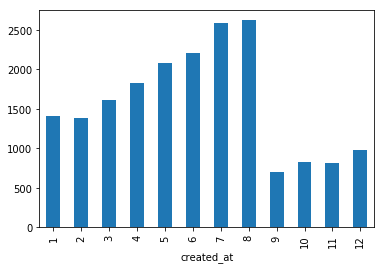

In [28]:
# Plot user creation in a histogram
users.groupby(users["created_at"].dt.month).count()['user_id'].plot(kind="bar")
plt.show()

Through this simple plot, I can immediately see that new user IDs were dramatically reduced after month 8. This could correspond to my hypothesis here, but it seems a bit strange that there would be increased user ID creation during the entire summer if seasonal employees were hired in June only. So the hypothesis may still fit, but it's looking more shakey; a company-wide disengagement might be more likely, but we can't rule out the seasonal employee effect. 

To get a better idea of this, I'm going to do the same sort of grouping. However, I'm going to join my table with the "events" table so that I can plot the number of events per time as a function of hiring month:

In [74]:
# Join the users and events on user ID
users_events = pd.merge(users, events, on=["user_id"], how= "inner")

users_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340825 entries, 0 to 340824
Data columns (total 12 columns):
user_id         340825 non-null float64
created_at      340825 non-null datetime64[ns]
company_id      340825 non-null float64
language        340825 non-null object
activated_at    336288 non-null datetime64[ns]
state           340825 non-null object
occurred_at     340825 non-null datetime64[ns]
event_type      340825 non-null object
event_name      340825 non-null object
location        340825 non-null object
device          340825 non-null object
user_type       325248 non-null float64
dtypes: datetime64[ns](3), float64(3), object(6)
memory usage: 33.8+ MB


This looks as expected. Now I want to do the following:

* Create the new column 'month' that shows the month a user joined
* Group events by the day they ocurred
* Plot events over time (count(event_name)), segmented by the grouped "created_at" month

In [80]:
# Add date on user creation PLUS pull out just date data, not time
users_events['month_created'] = users_events["created_at"].dt.month
users_events['date_minus_time'] = users_events["occurred_at"].apply( lambda df : 
                                                          datetime.datetime(year=df.year,                                                                                         
                                                                            month=df.month,
                                                                            day=df.day))

In [102]:
# Take just the columns I want for this exercise
hired_data = users_events[['user_id', 'month_created', 'date_minus_time']]
hired_data['total_users'] = 1
hired_data.head()

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,month_created,date_minus_time,total_users
0,4.0,1,2014-05-13,1
1,4.0,1,2014-05-13,1
2,4.0,1,2014-05-13,1
3,4.0,1,2014-05-13,1
4,4.0,1,2014-05-24,1


In [149]:
# Group by month_created and date_minus_time, then plot!
test = hired_data.groupby(['date_minus_time', 'month_created'], as_index=False).count()
test.head()

,date_minus_time,month_created,user_id,total_users
0,2014-05-01,1,167,167
1,2014-05-01,2,223,223
2,2014-05-01,3,348,348
3,2014-05-01,4,882,882
4,2014-05-01,5,512,512


In [150]:
test_week = test
test_week['week_occurred'] = test_month['date_minus_time'].dt.week
test_week.head()

,date_minus_time,month_created,user_id,total_users,week_occurred
0,2014-05-01,1,167,167,18
1,2014-05-01,2,223,223,18
2,2014-05-01,3,348,348,18
3,2014-05-01,4,882,882,18
4,2014-05-01,5,512,512,18


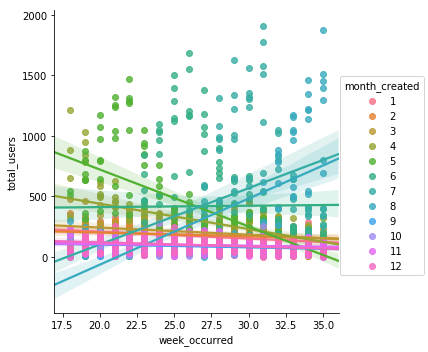

In [154]:
sns.lmplot(x = 'week_occurred', y = 'total_users', 
           hue = 'month_created', data = test_week)
plt.show()

This is somewhat useful; it looks like users created in months 4-9 are what's driving this; we'll filter those out, then re-plot

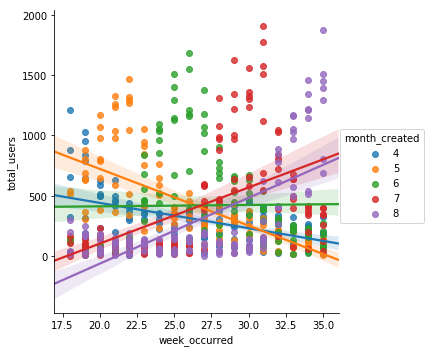

In [157]:
sns.lmplot(x = 'week_occurred', y = 'total_users', 
           hue = 'month_created', 
           data = test_week[np.logical_and(test_week.month_created > 3, test_week.month_created < 9)])
plt.show()

This is interesting at least; I think this will require re-working the dataset to better examine. Specifically:

* Go back to the users-events merged data frame
* Change it so it's just 1 user per day
* Re-do the plot

So this means really just taking the same dataset and removing duplicate users

In [159]:
hired_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340825 entries, 0 to 340824
Data columns (total 4 columns):
user_id            340825 non-null float64
month_created      340825 non-null int64
date_minus_time    340825 non-null datetime64[ns]
total_users        340825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 23.0 MB


In [160]:
hired_data_per_user = hired_data.drop_duplicates()
hired_data_per_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38474 entries, 0 to 340824
Data columns (total 4 columns):
user_id            38474 non-null float64
month_created      38474 non-null int64
date_minus_time    38474 non-null datetime64[ns]
total_users        38474 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.5 MB


This looks pretty much the same; now I need to take a look at what needs to be changed and do it!

In [161]:
hired_data_per_user.head()

,user_id,month_created,date_minus_time,total_users
0,4.0,1,2014-05-13,1
4,4.0,1,2014-05-24,1
6,4.0,1,2014-05-31,1
16,4.0,1,2014-05-20,1
22,4.0,1,2014-05-27,1


In [163]:
# Group by month_created and date_minus_time, then plot!
test_week = hired_data_per_user.groupby(['date_minus_time', 'month_created'], as_index=False).count()
test_week['week_occurred'] = test_week['date_minus_time'].dt.week
test_week.head()

,date_minus_time,month_created,user_id,total_users,week_occurred
0,2014-05-01,1,18,18,18
1,2014-05-01,2,28,28,18
2,2014-05-01,3,35,35,18
3,2014-05-01,4,87,87,18
4,2014-05-01,5,81,81,18


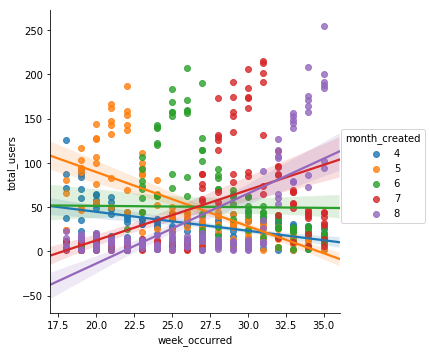

In [164]:
sns.lmplot(x = 'week_occurred', y = 'total_users', 
           hue = 'month_created', 
           data = test_week[np.logical_and(test_week.month_created > 3, test_week.month_created < 9)])
plt.show() 

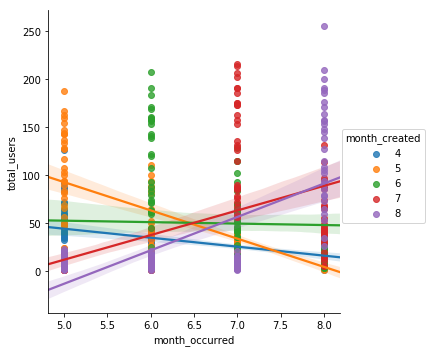

In [169]:
# Group by month_created and date_minus_time, then plot!
test_month = hired_data_per_user.groupby(['date_minus_time', 'month_created'], as_index=False).count()
test_month['month_occurred'] = test_month['date_minus_time'].dt.month
sns.lmplot(x = 'month_occurred', y = 'total_users', 
           hue = 'month_created', 
           data = test_month[np.logical_and(test_month.month_created > 3, 
                                            test_month.month_created < 9)])
plt.show() 

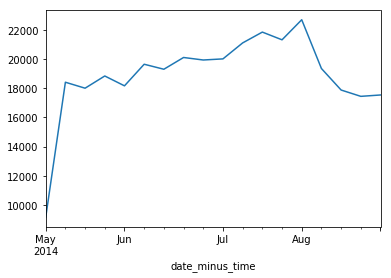

In [108]:
by_day = users_events
by_day.set_index(by_day["date_minus_time"],inplace=True)
by_day = users_events.resample('W').count()
by_day['user_id'].plot()
plt.show()

I have my date here, plus I have the month created. What I need to do is group by the date AND the month created, then count events in each case

In [116]:
users_events.head()

,user_id,created_at,company_id,language,activated_at,state,occurred_at,event_type,event_name,location,device,user_type,month_created,date_minus_time
date_minus_time,,,,,,,,,,,,,,
2014-05-13,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,3.0,1,2014-05-13
2014-05-13,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:32:10,engagement,home_page,India,lenovo thinkpad,3.0,1,2014-05-13
2014-05-13,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:32:26,engagement,search_autocomplete,India,lenovo thinkpad,3.0,1,2014-05-13
2014-05-13,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:32:58,engagement,search_autocomplete,India,lenovo thinkpad,3.0,1,2014-05-13
2014-05-24,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-24 11:39:53,engagement,login,India,samsung galaxy s4,3.0,1,2014-05-24


# Part 3: Is there a company-wide abandonment?

My next hypothesis is that 1 or more companies have abandoned the platform. For this, I want to plot the events against time, doing so by company. This requires my users_events dataframe

In [120]:
users_events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 340825 entries, 2014-05-13 to 2014-08-31
Data columns (total 14 columns):
user_id            340825 non-null float64
created_at         340825 non-null datetime64[ns]
company_id         340825 non-null float64
language           340825 non-null object
activated_at       336288 non-null datetime64[ns]
state              340825 non-null object
occurred_at        340825 non-null datetime64[ns]
event_type         340825 non-null object
event_name         340825 non-null object
location           340825 non-null object
device             340825 non-null object
user_type          325248 non-null float64
month_created      340825 non-null int64
date_minus_time    340825 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(3), int64(1), object(6)
memory usage: 39.0+ MB


Want:

* A plot with user events per company per week

In [134]:
# Plot user creation in a histogram
company_data = users_events[['date_minus_time', 'company_id']]
company_data['total_events'] = 1
company_data = company_data.groupby(["date_minus_time", "company_id"], as_index = False).count()

company_data.head()

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'date_minus_time' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


,date_minus_time,company_id,total_events
0,2014-05-01,1.0,223
1,2014-05-01,2.0,105
2,2014-05-01,3.0,69
3,2014-05-01,4.0,45
4,2014-05-01,5.0,8


In [132]:
company_data.company_id.describe()

count    32368.000000
mean      5340.708601
std       4251.663427
min          1.000000
25%        988.000000
50%       5001.000000
75%       9025.000000
max      13197.000000
Name: company_id, dtype: float64

In [133]:
len(company_data.company_id.unique())

6950

# Part 4: Changes in Event Types with Time

I want to examine the types of events happening with time

# Solution

* I think the most likely explanation is that seasonal employees ended their employment periods at the beginning of August; these were employees hired around April/May
* As evidence, employees hired past May have actually stayed about the same or INCREASED their event frequency as shown below

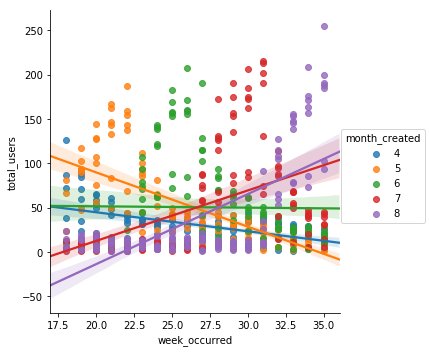

In [165]:
sns.lmplot(x = 'week_occurred', y = 'total_users', 
           hue = 'month_created', 
           data = test_week[np.logical_and(test_week.month_created > 3, test_week.month_created < 9)])
plt.show() 

Based upon this takeaway, I recommend that the higher-ups should not panic. User engagement should return to a stable level going forward. This cycle will likely repeat the following summer. 